# Project setup

In [3]:
dataset_zip_name = "mikroszkop-bioszenzor"
dataset_name = "20210526_LCLC_fn"
model_name = "cyto3_old_annotated"

In [ ]:
!git clone --recursive -j8 https://github.com/Nanobiosensorics/cell-aligner.git
!mv cell-aligner/* ./
!rm -rf cell-aligner

In [ ]:
!pip install -r requirements.txt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip "/content/drive/MyDrive/szakdolgozat/kepillesztes/{dataset_zip_name}.zip" -d "/content/datasets"
!mkdir models
!cp "/content/drive/MyDrive/szakmai gyakorlat/cellpose-cell-counting/models/{model_name}" "/content/models"

In [7]:
import os

file_path = "./nanobio_core/epic_cardio/data_correction.py"
backup_file_path = "./nanobio_core/epic_cardio/data_correction.bak"

if not os.path.exists(backup_file_path):
  os.rename(file_path, backup_file_path)

  with open(backup_file_path, 'r') as file:
    lines = file.readlines()

  with open(file_path, 'w') as file:
    for line in lines:
      if "matplotlib.use('Qt5Agg')" in line:
        file.write("# " + line)
      else:
        file.write(line)

# Evaluating with stochastic aligner

In [ ]:
import pickle
from pipeline import run_pipeline
from preprocessing import NanoReader

In [11]:
# no magnification
file_path = "/content/drive/MyDrive/szakdolgozat/kepillesztes/result_1x.pkl"

with open(file_path, "wb") as file:
  result = run_pipeline(
      data=NanoReader(
          base_path=f"/content/datasets/{dataset_name}",
          flip_epic=[False, True]
      ),
      mode=("stochastic", 1),
      cellpose_model_path=f"/content/models/{model_name}",
      epic_params={
        "preprocessing_params": {
            "magnification": 1,
            "scaling": "MIC_10X",
            "range_lowerbound": 0,
            "drift_correction": {
                "threshold": 75,
                "filter_method": "mean"
            }
        },
        "localization_params": {
            "threshold_range": [150, 3000],
            "neighbourhood_size": 3
        }
      }
  )
  pickle.dump(result, file)

Measurement mode normal
(153600,)
Measurement loaded (1314, 240, 320) time (1314,)
[(1, 169)]


/usr/local/lib/python3.10/dist-packages/cellpose/resnet_torch.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, map_location=device)


In [ ]:
# magnification
file_path = "/content/drive/MyDrive/szakdolgozat/kepillesztes/result_2x.pkl"

with open(file_path, "wb") as file:
  result = run_pipeline(
      data=NanoReader(
          base_path=f"/content/datasets/{dataset_name}",
          flip_epic=[False, True]
      ),
      mode=("stochastic", 1),
      cellpose_model_path=f"/content/models/{model_name}",
      epic_params={
        "preprocessing_params": {
            "magnification": 2,
            "scaling": "MIC_10X",
            "range_lowerbound": 0.8,
            "drift_correction": {
                "threshold": 75,
                "filter_method": "mean"
            }
        },
        "localization_params": {
            "threshold_range": [25, 5000],
            "neighbourhood_size": 3
        }
      }
  )
  pickle.dump(result, file)

## Evaluating results

In [12]:
import pickle

with open("/content/drive/MyDrive/szakdolgozat/kepillesztes/result_1x.pkl", "rb") as file:
  result_1x = pickle.load(file)

with open("/content/drive/MyDrive/szakdolgozat/kepillesztes/result_2x.pkl", "rb") as file:
  result_2x = pickle.load(file)

In [13]:
def show_alignment_result(ax, well_id, result):
  microscope_img, microscope_points = result[well_id][0]
  well_img, well_points, _ = result[well_id][1]
  translation = result[well_id][2]

  ax.set_axis_off()

  height1, width1 = microscope_img.shape[:2]
  height2, width2 = well_img.shape[:2]

  ax.imshow(microscope_img, cmap="gray")
  ax.scatter(
      microscope_points[:, 0], microscope_points[:, 1],
      color="red", alpha=0.25
  )
  ax.imshow(
      well_img, cmap="viridis", alpha=0.4,
      extent = [translation[0], translation[0]  + well_img.shape[0],
                translation[1] + well_img.shape[1], translation[1]]
  )

  ax.set_xlim([0, width1])
  ax.set_ylim([height1, 0])

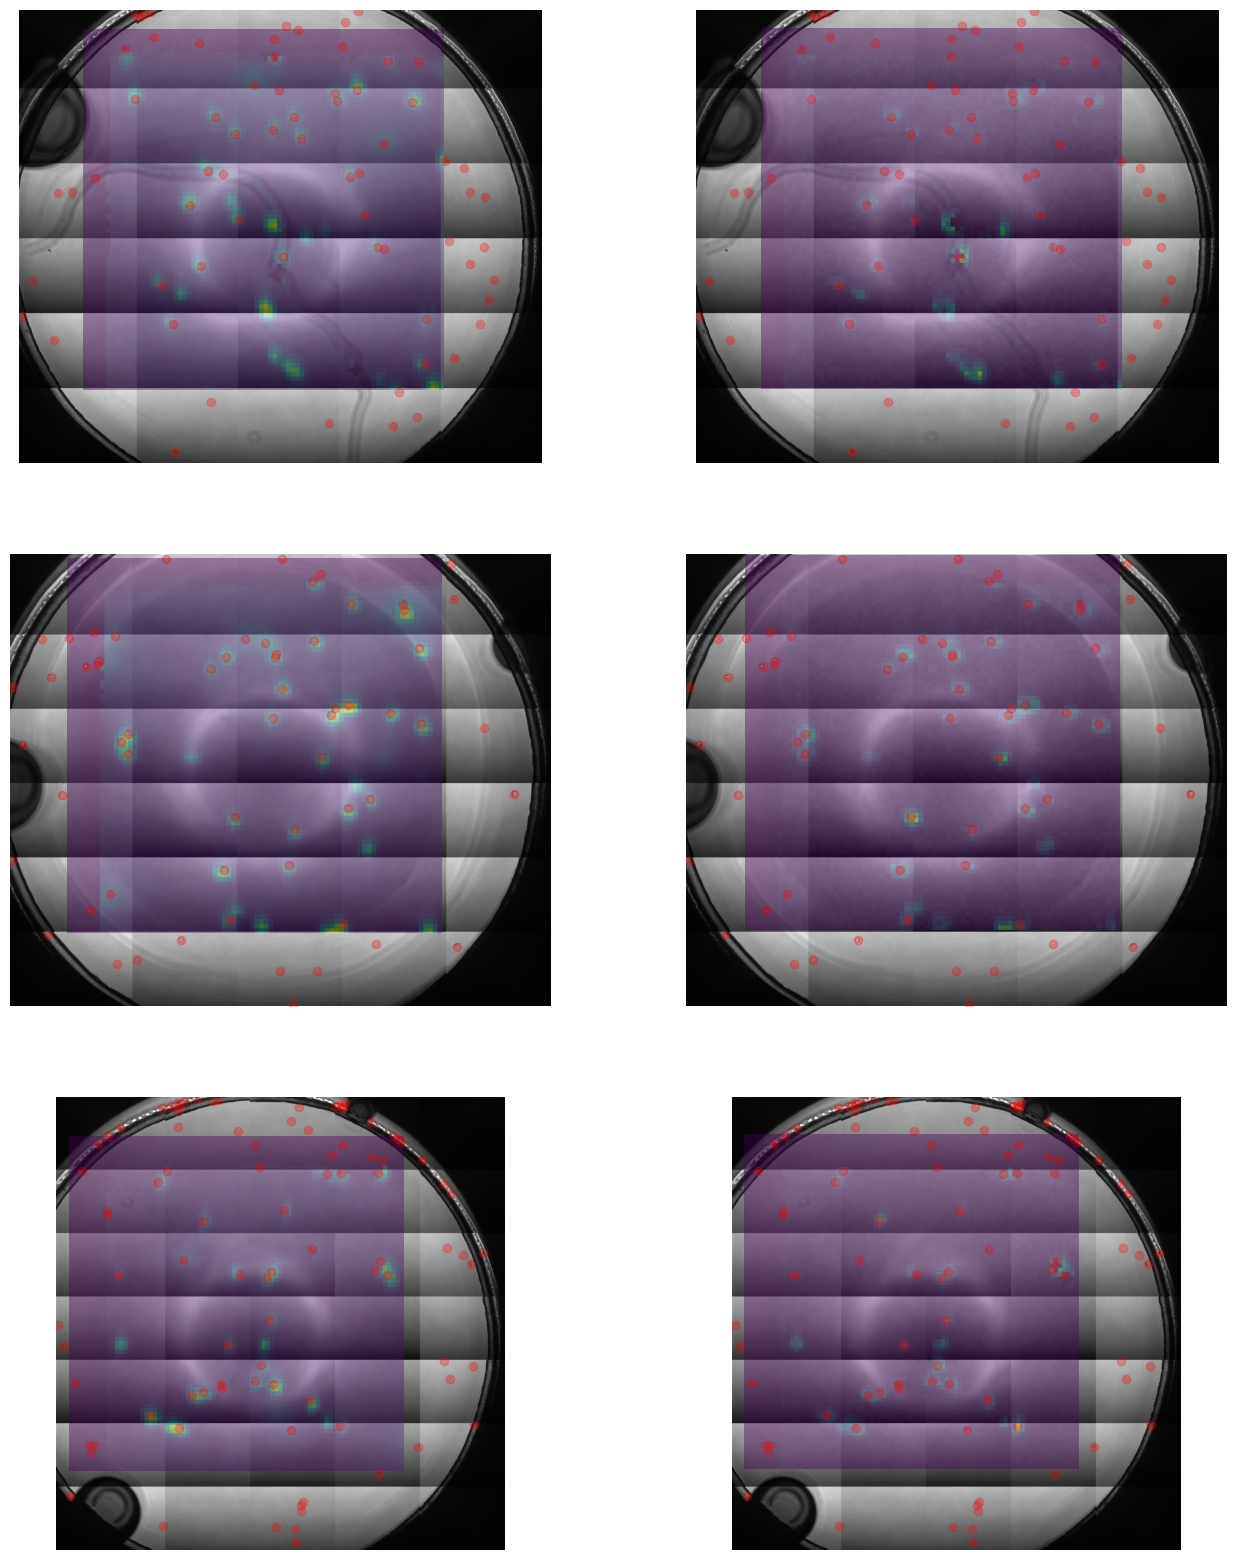

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(16, 20))

show_alignment_result(axes[0][0], "A1", result_1x)
show_alignment_result(axes[0][1], "A1", result_2x)

show_alignment_result(axes[1][0], "B1", result_1x)
show_alignment_result(axes[1][1], "B1", result_2x)

show_alignment_result(axes[2][0], "C1", result_1x)
show_alignment_result(axes[2][1], "C1", result_2x)